In [1]:
import os
import glob
from tqdm import tqdm
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import cv2
import ipyplot

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# LOAD

In [2]:
DATASET_FOLDER = 'data'

In [3]:
def load_dataset(dataset):
    data = np.load(f'{DATASET_FOLDER}/{dataset}.npz')
    imgs = data['imgs'].astype(np.float32)/255
    imgs = np.expand_dims(imgs, axis=-1)
    
    df = pd.read_csv(f'{DATASET_FOLDER}/{dataset}.csv')
    names = [name.replace('.png', '') for name in data['names']]
    assert (df.name == names).all()
    if 'label' in df.columns:
        labels = df.label.values
    else:
        labels = None
    
    return imgs, labels, names

In [4]:
train_imgs, train_labels, train_names = load_dataset('train')
test_imgs, test_labels, test_names = load_dataset('test')

In [172]:
train_imgs[0].shape

(28, 28, 1)

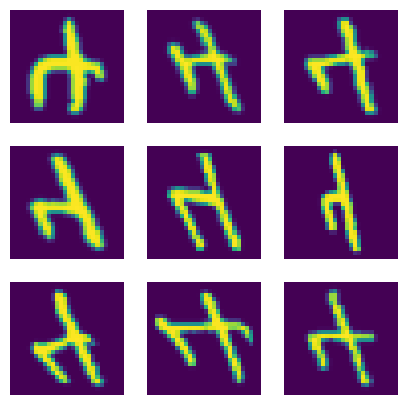

In [274]:
number_to_transform = 4
# # train_datagen = ImageDataGenerator(shear_range=40, horizontal_flip=True, vertical_flip=True)
# train_datagen = ImageDataGenerator(vertical_flip=True)
# # train_datagen.fit(train_imgs)
# train_datagen.fit(train_imgs[train_labels == number_to_transform])
# generator = train_datagen.flow(train_imgs[train_labels == number_to_transform])

plt.figure(figsize=(5, 5))
for i in range(9):
    # flip the image vertically
    image = cv2.flip(train_imgs[train_labels == number_to_transform][i], 0)
    cv2.imshow("image", image[0])
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image)
    plt.axis("off");
# print(image[0].shape)

In [5]:
numbers_to_flip = [4,7]

number_images_augmented = 0
for i in numbers_to_flip:
    number_images_augmented += np.sum(train_labels == i)
train_imgs_augmented = np.empty((number_images_augmented,)+(28,28,1))
train_labels_augmented = np.empty((number_images_augmented,))
train_labels_augmented.fill(10)

In [6]:
print(train_imgs.shape)
print(train_labels.shape)
print(train_imgs_augmented.shape)
print(train_labels_augmented.shape)

(60000, 28, 28, 1)
(60000,)
(12000, 28, 28, 1)
(12000,)


In [7]:
position = 0
for i in numbers_to_flip:
    for image_to_transform in train_imgs[train_labels == i]:
        train_imgs_augmented[position] = np.expand_dims(cv2.flip(image_to_transform, 0), 2)
        position+=1

In [232]:
# for i in tqdm(range(train_imgs.shape[0])):
#     augmented_image = generator.next()
#     train_imgs_augmented[i] = augmented_image[0]
# train_imgs_augmented = np.vstack((train_imgs,train_imgs_augmented))
# train_labels_augmented = np.append(train_labels,train_labels_augmented)

100%|██████████| 60000/60000 [01:43<00:00, 577.74it/s]


In [8]:
train_imgs_augmented = np.vstack((train_imgs,train_imgs_augmented))
train_labels_augmented = np.append(train_labels,train_labels_augmented)

In [9]:
print(train_imgs.shape)
print(train_labels.shape)
print(train_imgs_augmented.shape)
print(train_labels_augmented.shape)

(60000, 28, 28, 1)
(60000,)
(72000, 28, 28, 1)
(72000,)


In [230]:
# blackImage = np.zeros((28,28,1), dtype = np.uint8)
# org = (50, 50)
# font = cv2.FONT_HERSHEY_SIMPLEX
# fontScale = 1
# # Blue color in BGR
# color = (0,0,0)  
# # Line thickness of 2 px
# thickness = 2   
# # Using cv2.putText() method
# image = cv2.putText(image, 'OpenCV', org, font, 
#                    fontScale, color, thickness, cv2.LINE_AA)

In [234]:
# ipyplot.plot_class_tabs(train_imgs[..., 0], train_labels)
# ipyplot.plot_images(test_imgs[..., 0])

In [10]:
num_classes = 11
y_train = keras.utils.to_categorical(train_labels_augmented, num_classes)

In [11]:
val_ratio = 0.1
train_indices, val_indices = train_test_split(
    np.arange(len(train_imgs_augmented)), test_size=val_ratio,
    random_state=42, stratify=train_labels_augmented)

# MODEL

In [12]:
def get_model(num_classes, initial_filters=32, verbose=False):
    model = keras.Sequential(
        [
            keras.Input(shape=train_imgs.shape[1:]),
            layers.Conv2D(initial_filters, kernel_size=(3, 3), activation="relu"),
            layers.MaxPooling2D(pool_size=(2, 2)),
            layers.Conv2D(initial_filters*2, kernel_size=(3, 3), activation="relu"),
            layers.MaxPooling2D(pool_size=(2, 2)),
            layers.Flatten(),
            layers.Dropout(0.5),
            layers.Dense(num_classes, activation="softmax"),
        ]
    )

    if verbose:
        model.summary()
        
    return model

In [13]:
model = get_model(num_classes, verbose=False)
# model = get_model(11, verbose=True)
# keras.utils.plot_model(model, show_shapes=True)

Metal device set to: Apple M1

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



2023-09-09 16:36:37.318921: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-09-09 16:36:37.319094: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


# TRAIN

In [15]:
epochs = 100
batch_size = 128

model = get_model(num_classes)
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

callbacks=[
    keras.callbacks.EarlyStopping(patience=20, monitor='val_accuracy', verbose=True),
    keras.callbacks.ReduceLROnPlateau(patience=3, factor=0.5, monitor='val_loss', verbose=True)
]

ret = model.fit(train_imgs_augmented[train_indices], y_train[train_indices],
                validation_data=(train_imgs_augmented[val_indices],y_train[val_indices]),
                batch_size=batch_size, epochs=epochs,
                callbacks=callbacks, verbose=1);

Epoch 1/100


2023-09-09 16:36:43.786232: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-09-09 16:36:43.970565: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


507/507 [==============================] - ETA: 0s - loss: 0.3262 - accuracy: 0.8991

2023-09-09 16:36:53.408074: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


507/507 [==============================] - 10s 19ms/step - loss: 0.3262 - accuracy: 0.8991 - val_loss: 0.0965 - val_accuracy: 0.9732 - lr: 0.0010
Epoch 2/100
507/507 [==============================] - 9s 19ms/step - loss: 0.0983 - accuracy: 0.9711 - val_loss: 0.0639 - val_accuracy: 0.9815 - lr: 0.0010
Epoch 3/100
507/507 [==============================] - 9s 18ms/step - loss: 0.0765 - accuracy: 0.9776 - val_loss: 0.0539 - val_accuracy: 0.9853 - lr: 0.0010
Epoch 4/100
507/507 [==============================] - 9s 18ms/step - loss: 0.0637 - accuracy: 0.9814 - val_loss: 0.0544 - val_accuracy: 0.9850 - lr: 0.0010
Epoch 5/100
507/507 [==============================] - 9s 18ms/step - loss: 0.0534 - accuracy: 0.9838 - val_loss: 0.0457 - val_accuracy: 0.9865 - lr: 0.0010
Epoch 6/100
507/507 [==============================] - 9s 18ms/step - loss: 0.0498 - accuracy: 0.9858 - val_loss: 0.0414 - val_accuracy: 0.9878 - lr: 0.0010
Epoch 7/100
507/507 [==============================] - 9s 18ms/step -

In [14]:
def plot_train_evolution(ret):
    print()
    for key in ['accuracy', 'val_accuracy']:
        print(f'best {key}: {np.max(ret.history[key]):.3f}')
        values = 1-np.array(ret.history[key])
        label = key.replace('accuracy', 'error') + f' min value {np.min(values):.1e}'
        plt.plot(values, label=label)
    plt.yscale('log')
    plt.title(f'Max val accuracy {np.max(ret.history["val_accuracy"]):.3f}')
    plt.legend(loc=0);
    plt.xlabel('Epoch')
    plt.ylabel('Error')
    plt.grid(which='both')


best accuracy: 0.998
best val_accuracy: 0.994


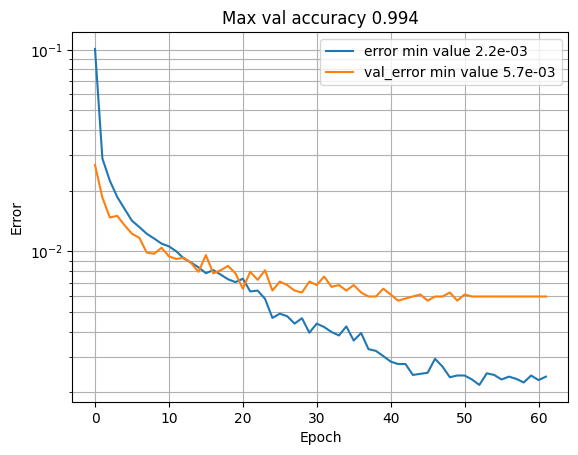

In [16]:
plot_train_evolution(ret)

In [17]:
test_preds = model.predict(test_imgs, batch_size=128, verbose=1)

 31/157 [====>.........................] - ETA: 0s

2023-09-09 16:46:46.639514: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


157/157 [==============================] - 1s 6ms/step


# VISUALIZE

In [ ]:
def visualize_test_img_and_pred(idx):
    plt.subplot(121)
    plt.imshow(test_imgs[idx])
    plt.subplot(122)
    #plt.plot(test_preds[idx])
    plt.bar(np.arange(10), test_preds[idx])
    plt.title(f'Max pred {np.max(test_preds[idx]):.2f}')
    plt.ylim(0, 1)
    plt.xticks(np.arange(10))

In [ ]:
# for idx in range(10):
#     visualize_test_img_and_pred(idx)
#     plt.show()

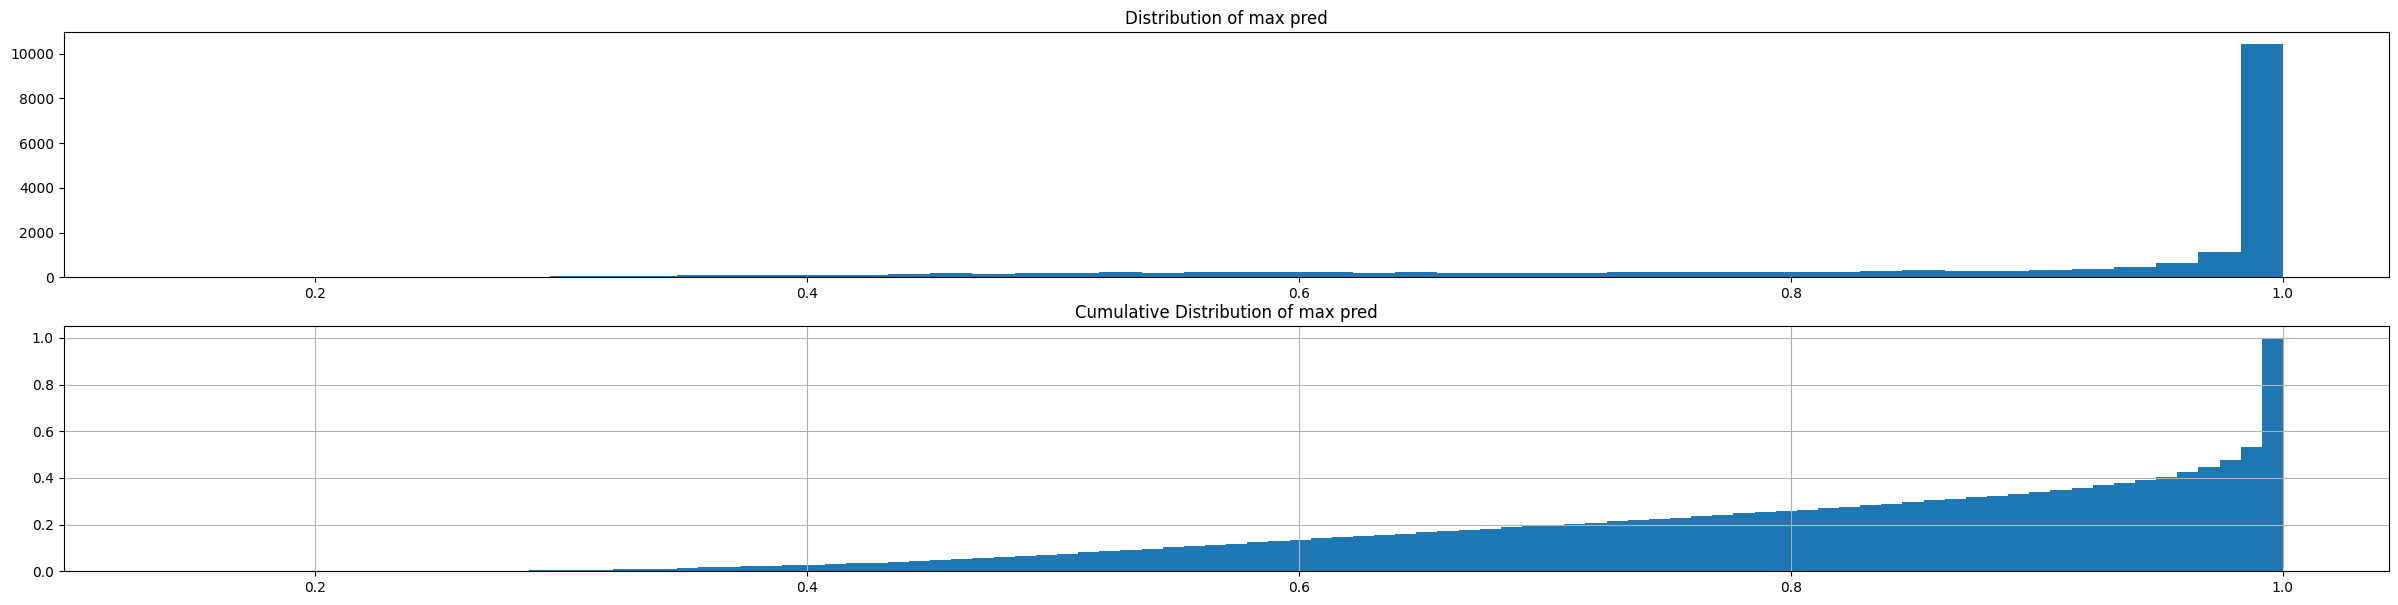

In [ ]:
plt.figure(figsize=(30, 7))
max_test_preds = np.max(test_preds, axis=1)
plt.subplot(211)
plt.title('Distribution of max pred')
plt.hist(max_test_preds, bins=50);
plt.subplot(212)
plt.title('Cumulative Distribution of max pred')
plt.hist(max_test_preds, bins=100, cumulative=1, density=True);
plt.grid()

# SUBMIT

In [26]:
test_labels = np.argmax(test_preds, axis=1)
max_test_preds = np.max(test_preds, axis=1)
test_labels[max_test_preds < np.median(max_test_preds)] = 10
nPrediccionesPorClase = np.unique(test_labels, return_counts=True)
display(pd.Series(nPrediccionesPorClase[1]))

0      1157
1      1009
2      1041
3       935
4       967
5       980
6       982
7       895
8      1000
9       870
10    10202
dtype: int64

In [30]:
# porcentaje de no numeros predecido
np.round(nPrediccionesPorClase[1][10]*100/test_labels.shape[0],2)

50.91

In [31]:
submission = pd.read_csv(f'{DATASET_FOLDER}/sample_submission.csv')
assert (submission.name == test_names).all()
submission['label'] = test_labels
submission.head()

,name,label
0,000245159744cee166bd566168033e37,10
1,0002fa2768dff946a9440ba527b7094c,0
2,000e6e1550101554e232afc958ad07ca,6
3,0015f3f045a3d501fd0015a3cdd8a918,10
4,0018f902cf6145276b7703b35f77f6e4,10


In [32]:
submission.to_csv('submission.csv', index=False)